<a href="https://colab.research.google.com/github/prashantiyaramareddy/AI-ML-Learnings/blob/master/ComputerVision/AlexNet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AlexNet Implementation in Pytorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms,models
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [15]:
torch.__version__

'2.9.0+cu126'

In [16]:
# Check GPU Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define transforms to be applied on dataset

In [17]:
from torch.nn.modules import padding
# Use the mean and sta from the CIFAR10
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)), # Corrected: size should be a tuple
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Corrected: size should be a tuple
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [18]:
### Import Dataset
from torchvision.datasets import CIFAR10
full_training_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

In [19]:
### Create DataLoader
val_size = 5000
train_Size = len(full_training_dataset) - val_size
train_dataset, val_dataset = random_split(full_training_dataset, [train_Size, val_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64,pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64,pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64,pin_memory=True)

In [20]:
len(train_loader),len(test_loader),len(val_loader)

(704, 157, 79)

In [22]:
### Load Pretrained Model
alexnet = models.alexnet(pretrained=True)

# Freeze all layers
for param in alexnet.parameters():
  param.requires_grad = False

# Replace the last fully connected layer
num_classes = 10
alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Only the new final layer should be trainable
for param in alexnet.classifier[6].parameters():
  param.requires_grad = True

alexnet = alexnet.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
## Train the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

model = alexnet

In [28]:
from google.colab import output
epochs = 20

for epoch in range(epochs):
  model.train()
  totalEpochLoss = 0
  for images, labels in train_loader:
    # Move to GPU
    images, labels = images.to(device), labels.to(device)

    # forward pass
    outputs = model(images)

    # Calculate Loss
    loss = criterion(outputs, labels)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    totalEpochLoss += loss.item()

avg_loss = totalEpochLoss / len(train_loader)

# Print avg loss
print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Validation
model.eval()
val_loss = 0.0

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)

print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

#Step the scheduler with validation loss
scheduler.step(avg_val_loss)

# Save the checkpoint every 10 epochs
if (epoch + 1) % 10 == 0:
  checkpoint_path = f'checkpoint_epoch_{epoch + 1}.pth'
  torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': avg_loss,
  }, checkpoint_path)
  print(f"Checkpoint saved at {checkpoint_path}")




Epoch [20/20], Loss: 0.6816
Epoch [20/20], Validation Loss: 0.6342
Checkpoint saved at checkpoint_epoch_20.pth


In [29]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
### Evaluation in test dataset

In [33]:
total = 0
correct = 0

with torch.no_grad():
  for batchFeatures, batchLabels in test_loader:
    # move to gpu
    batchFeatures, batchLabels = batchFeatures.to(device), batchLabels.to(device)

    # Forward pass
    outputs = model(batchFeatures)

    # Calculate Loss
    _, predicted = torch.max(outputs.data, 1)
    total += batchLabels.size(0)
    correct += (predicted == batchLabels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 78.70%


### Evaluation on Training set


In [34]:
total = 0
correct = 0

with torch.no_grad():
  for batchFeatures,batchLabels in train_loader:
    # move to gpu
    batchFeatures, batchLabels = batchFeatures.to(device), batchLabels.to(device)

    # Forward passs
    outputs = model(batchFeatures)

    # Calculate Loss
    _, predicted = torch.max(outputs.data, 1)
    total += batchLabels.size(0)
    correct += (predicted == batchLabels).sum().item()

accuracy = correct / total

print(f"Accuracy on train set:{accuracy}")

Accuracy on train set:0.7933111111111111


### Predictions

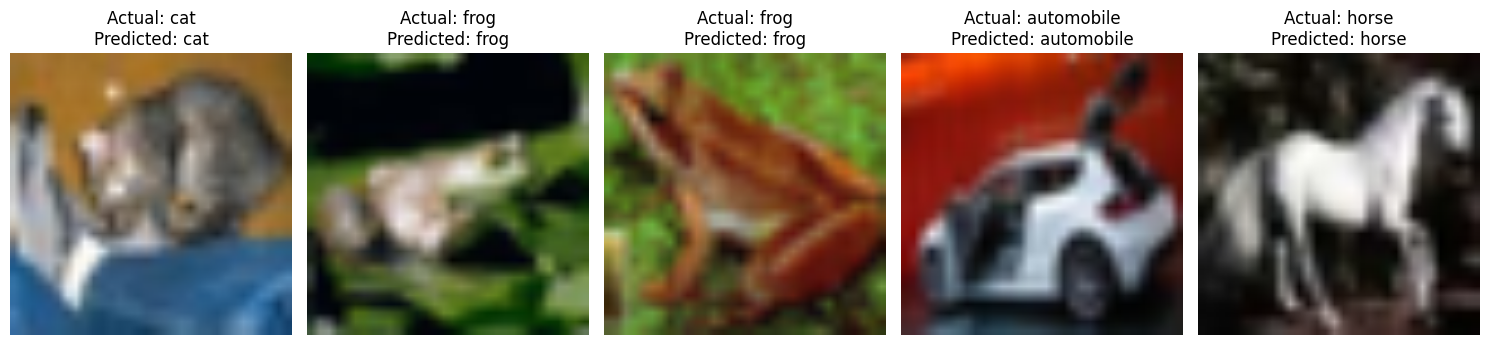

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample

# Define CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Set model to evaluation mode
model.eval()

# Disable gradients for prediction
with torch.no_grad():
  for batchFeatures, batchLabels in test_loader:
    # Move to GPU
    batchFeatures, batchLabels = batchFeatures.to(device), batchLabels.to(device)

    # Forward pass
    outputs = model(batchFeatures)

    _, predicted_indices = torch.max(outputs.data, 1)

    # Select N random images
    N = 5
    indices = sample(range(len(batchFeatures)), N)

    # Plot the images using the axes object
    fig, axes = plt.subplots(1, N, figsize=(15, 5))

    # Plot images with actual and predicted labels
    for i in range(N):
      idx = indices[i]

      # Get image, label and predicted labels
      img = batchFeatures[idx].cpu()
      actual = classes[batchLabels[idx].item()]
      predicted_label = classes[predicted_indices[idx].item()]

      # Denormalize image for diaplay
      img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
      img = img.permute(1,2,0)
      img = torch.clamp(img, 0, 1)

      # Plot image on the respective subplot axis
      axes[i].imshow(img)
      axes[i].set_title(f"Actual: {actual}\nPredicted: {predicted_label}")
      axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    break